# Distortion analyses in NISP simulations

**Author:** Yannick Copin <y.copin@ipnl.in2p3.fr>

In [1]:
%matplotlib inline

# try:
#     import mpld3  # Interactive plots
#     mpld3.enable_notebook()
# except ImportError:
#     pass

try:
    import seaborn
    seaborn.set_style('ticks', {"axes.grid": True})
except ImportError:
    pass

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as N
from matplotlib import pyplot as P
from spectrogrism import spectrogrism as S
from spectrogrism import nisp
from spectrogrism import distortion as D

In [3]:
datapath = "../spectrogrism/data/"
simulations = S.Configuration([
    ("name", "Zemax"),
    (1, datapath + "run_190315.dat"),            # 1st-order dispersed simulation
    (0, datapath + "run_011115_conf2_o0.dat"),   # 0th-order dispersed simulation
    (2, datapath + "run_161115_conf2_o2.dat"),   # 2nd-order dispersed simulation
    ('J', datapath + "run_071215_conf6_J.dat"),  # J-band undispersed simulation
])
zmx = nisp.ZemaxPositions(simulations)
print(zmx)

Simulations 'Zemax': 4 modes
  Order #1: ../spectrogrism/data/run_190315.dat
  Order #0: ../spectrogrism/data/run_011115_conf2_o0.dat
  Order #2: ../spectrogrism/data/run_161115_conf2_o2.dat
  Band   J: ../spectrogrism/data/run_071215_conf6_J.dat
  Wavelengths: 13 steps from 1.20 to 1.80 µm
  Coords: 289 sources


## Photometric modes

### Band J

In [4]:
df = zmx['J']
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 13 entries, 1.2e-06 to 1.8e-06
Columns: 289 entries, (-0.006981317008-0.006981317008j) to (0.006981317008+0.006981317008j)
dtypes: complex128(289)
memory usage: 58.8 KB


Restructure mean position (averaged over wavelengths) into an *ad-hoc* structured grid:

In [5]:
xy = df.mean(axis=0).values  # Mean (complex) positions (averaged over wavelengths) (289,)
xy = xy.reshape(-1, 17)      # (17, 17)
grid = D.StructuredGrid(xy)
print(grid)

Structured grid: 17 x 17 = 289 positions, y-x-


Estimate *effective undistorted* grid properties (step, rotation, minimal distortion position) from triangulation analysis (no optical modeling):

Offset: (0.001, 0.000), step: 0.011, angle: 0.0°
Center of distortion: (-0.001, -0.012)


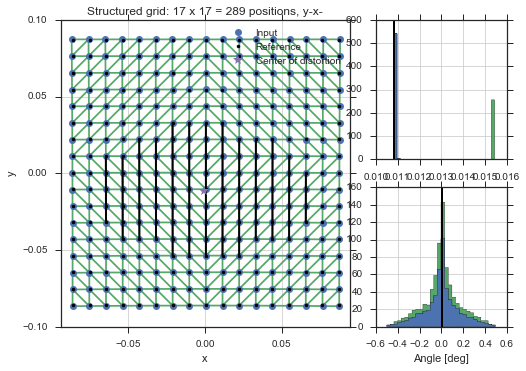

In [6]:
step, angle, offset, center = grid.estimate_parameters(fig=True)
print(u"Offset: ({0.real:.3f}, {0.imag:.3f}), step: {1:.3f}, angle: {2:.1f}°"
     .format(offset, step, N.rad2deg(angle)))
print(u"Center of distortion: ({0.real:.3f}, {0.imag:.3f})".format(center))

Construct *effective undistorted* grid used as reference:

In [7]:
refgrid = D.StructuredGrid.create(grid.nx, grid.ny, step=step, rotation=angle, offset=offset)
refgrid.reorder(grid.signature)
print(refgrid)

Structured grid: 17 x 17 = 289 positions, y-x-


Compute offset RMS between observed *distorted* (`grid`) and reference *undistorted* (`refgrid`) grids: 

RMS = 0.313 mm = 17.4 px


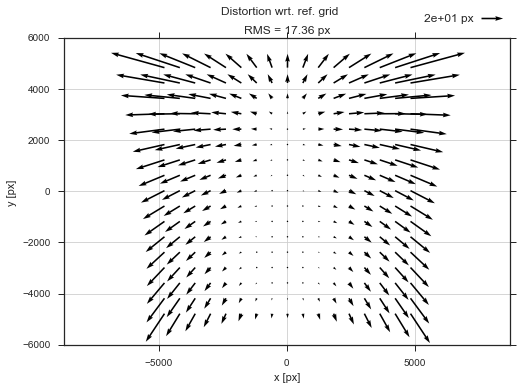

In [8]:
rms = grid.rms(refgrid.xy)
print("RMS = {:.3g} mm = {:.3g} px".format(rms / 1e-3, rms / 18e-6))

ax = grid.plot_offsets(refgrid, units=(18e-6, 'px'))
ax.figure.suptitle("Distortion wrt. ref. grid");

It is already apparent that the distortion will not be well approximated by a radial expansion. This is an hint of off-axis optics.

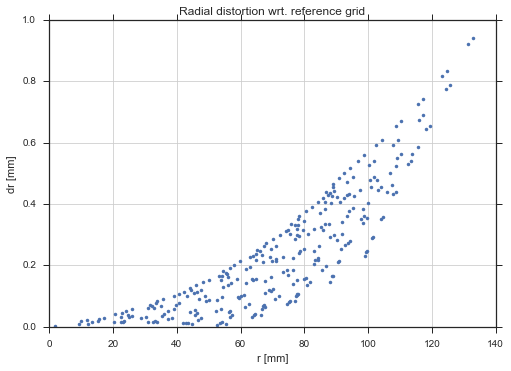

In [9]:
dxy = grid.xy - refgrid.xy
r = N.abs(grid.xy - center).ravel()
dr = N.hypot(dxy.real, dxy.imag).ravel()

fig, ax = P.subplots(subplot_kw={'title': "Radial distortion wrt. reference grid",
                                 'xlabel': "r [mm]", 'ylabel': "dr [mm]"})
ax.plot(r / 1e-3, dr / 1e-3, '.');

Adjust the distortion with a simple r² radial expansion:

In [10]:
dist = D.GeometricDistortion(center, Kcoeffs=[0.], Pcoeffs=[])
print(dist)

Geometric distortion: center=(-0.000581568, -0.0117205), K-coeffs=[ 0.], P-coeffs=[]


In [11]:
minuit = refgrid.adjust_distortion(grid, dist, scale=True, offset=True)

minuit.print_matrix()
adjrms = minuit.fval ** 0.5  # objfun is RMS**2
print("RMS = {:.4f} mm = {:.2f} px".format(adjrms / 1e-3, adjrms / 18e-6))

FCN = 2.95884139728e-08 
 TOTAL NCALL = 81 
 NCALLS = 81 
 
 
 EDM = 3.52836930647e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x0,-0.000581568,3066.74,0,0,,,
2,y0,-0.0117205,440.968,0,0,,,
3,K1,0.197522,15443.2,0,0,,,
4,scale,1.00178,120.952,0,0,,,
5,dx,2.23496e-06,7.18037,0,0,,,
6,dy,-2.67727e-05,1.92654,0,0,,,


+,x0,y0,K1,scale,dx,dy
x0,1.00,-0.62,-0.96,0.95,0.99,0.73
y0,-0.62,1.00,0.65,-0.63,-0.61,-0.19
K1,-0.96,0.65,1.00,-0.99,-0.95,-0.76
scale,0.95,-0.63,-0.99,1.00,0.94,0.76
dx,0.99,-0.61,-0.95,0.94,1.00,0.72
dy,0.73,-0.19,-0.76,0.76,0.72,1.00


RMS = 0.1720 mm = 9.56 px


Reconstruct adjusted *distorted* grid from fit parameters:

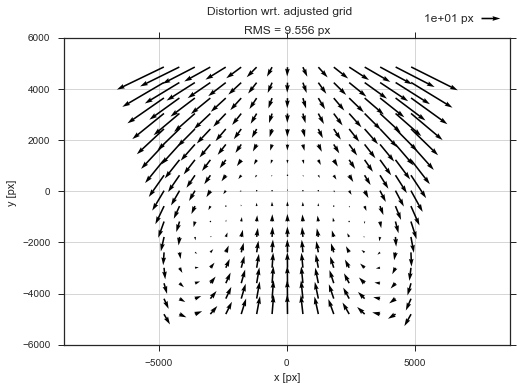

In [12]:
adjdist = D.GeometricDistortion.from_kwargs(**minuit.values)
adjgrid = D.StructuredGrid(adjdist.forward(refgrid.xy))

ax = grid.plot_offsets(adjgrid, units=(18e-6, 'px'))
ax.figure.suptitle("Distortion wrt. adjusted grid");

Given the fact that the off-axis distortion pattern will not be well approximated by a radial expansion, one can test a generic polynomial expansion:

In [13]:
from spectrogrism import polyfit

poldeg = (3, 3)
print("Total number of coeff.: {}".format((poldeg[0] + 1) * (poldeg[1] + 1)))
px = polyfit.fit_legendre2D(refgrid.x, refgrid.y, dxy.real.ravel(), deg=poldeg)
py = polyfit.fit_legendre2D(refgrid.x, refgrid.y, dxy.imag.ravel(), deg=poldeg)

Total number of coeff.: 16


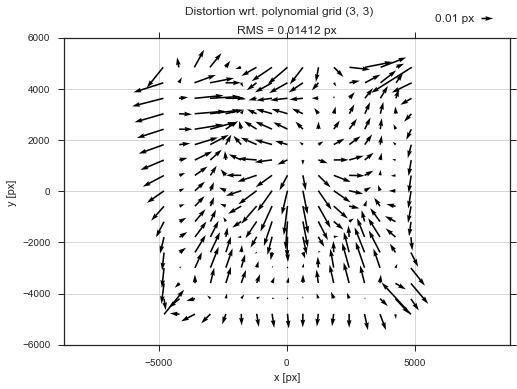

In [14]:
polygrid = D.StructuredGrid(refgrid.xy + 
                            px(refgrid.xy.real, refgrid.xy.imag) + 
                            py(refgrid.xy.real, refgrid.xy.imag) * 1j)

ax = grid.plot_offsets(polygrid, units=(18e-6, 'px'))
ax.figure.suptitle("Distortion wrt. polynomial grid {}".format(poldeg));

## Spectroscopic modes

### Order 1

Offset: (0.001, -0.003), scale: 0.011, angle: 0.0°
Center of distortion: (-0.002, -0.014)


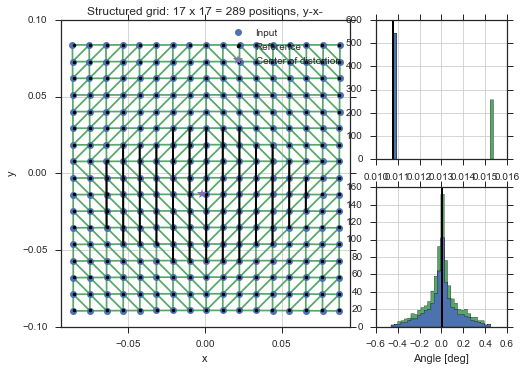

In [15]:
df = zmx[1]
grid = D.StructuredGrid(df.mean(axis=0).values.reshape(-1, 17))

step, angle, offset, center = grid.estimate_parameters(fig=True)
print(u"Offset: ({0.real:.3f}, {0.imag:.3f}), scale: {1:.3f}, angle: {2:.1f}°"
     .format(offset, step, N.rad2deg(angle)))
print(u"Center of distortion: ({0.real:.3f}, {0.imag:.3f})".format(center))

RMS = 0.289 mm = 16.1 px


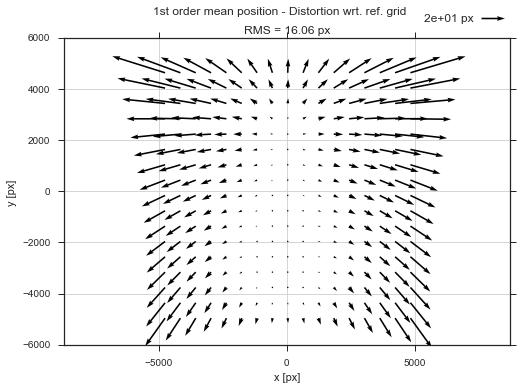

In [16]:
refgrid = D.StructuredGrid.create(grid.nx, grid.ny, step=step, rotation=angle, offset=offset)
refgrid.reorder(grid.signature)  # Reference (undistorted) grid

rms = grid.rms(refgrid.xy)
print("RMS = {:.3g} mm = {:.3g} px".format(rms / 1e-3, rms / 18e-6))

ax = grid.plot_offsets(refgrid, units=(18e-6, 'px'))
ax.figure.suptitle("1st order mean position - Distortion wrt. ref. grid");

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x0,-0.00228121,0.0074834,0,0,,,
2,y0,-0.0137074,0.0074834,0,0,,,
3,K1,0,0.001,0,0,,,
4,scale,1,0.01,0,0,,,
5,dx,0,0.000289115,0,0,,,
6,dy,0,0.000289115,0,0,,,


FCN = 2.31410845187e-08 
 TOTAL NCALL = 83 
 NCALLS = 83 
 
 
 EDM = 6.54738621888e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x0,-0.00228121,1160.23,0,0,,,
2,y0,-0.0137074,360.647,0,0,,,
3,K1,0.189796,5916.25,0,0,,,
4,scale,1.00167,49.9196,0,0,,,
5,dx,4.83733e-06,2.81307,0,0,,,
6,dy,-2.22931e-05,1.53002,0,0,,,


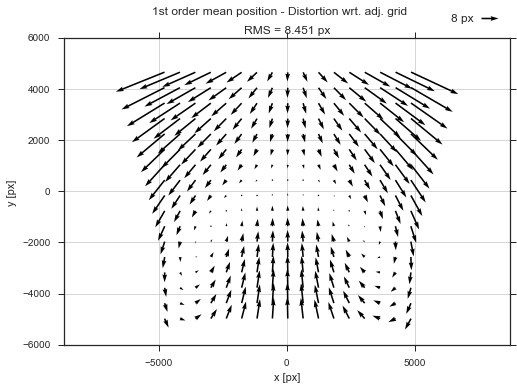

In [17]:
dist = D.GeometricDistortion(center, Kcoeffs=[0.])
minuit = refgrid.adjust_distortion(grid, dist, scale=True, offset=True, print_level=2)

adjdist = D.GeometricDistortion.from_kwargs(**minuit.values)
adjgrid = D.StructuredGrid(adjdist.forward(refgrid.xy))

ax = grid.plot_offsets(adjgrid, units=(18e-6, 'px'))
ax.figure.suptitle("1st order mean position - Distortion wrt. adj. grid");

### Order 0

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x0,0,0.00760277,0,0,,,
2,y0,0,0.00760277,0,0,,,
3,scale,1,0.01,0,0,,,
4,dx,0,0.000564474,0,0,,,
5,dy,0,0.000564474,0,0,,,


FCN = 8.25932987863e-08 
 TOTAL NCALL = 64 
 NCALLS = 64 
 
 
 EDM = 5.46896901308e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x0,0,2,0,0,,,
2,y0,0,2,0,0,,,
3,scale,1.00589,1.97807,0,0,,,
4,dx,5.84e-06,0.894428,0,0,,,
5,dy,0.000116242,0.894786,0,0,,,


RMS = 0.326 mm = 18.1 px


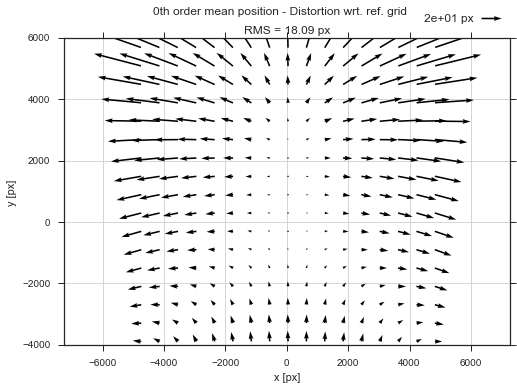

In [18]:
df0 = zmx[0]
grid0 = D.StructuredGrid(df0.mean(axis=0).values.reshape(-1, 17))  # Observed grid

step, angle, offset, center = grid0.estimate_parameters()  # Initial parameters
refgrid0 = D.StructuredGrid.create(grid0.nx, grid0.ny, step=step, rotation=angle, offset=offset)
refgrid0.reorder(grid0.signature)  # Reference (undistorted) grid

# Adjust minimal mapping: scale + offset
dist0 = D.GeometricDistortion() 
minuit0 = refgrid0.adjust_distortion(grid0, dist0, scale=True, offset=True, print_level=2)

adjdist0 = D.GeometricDistortion.from_kwargs(**minuit.values)
adjgrid0 = D.StructuredGrid(adjdist0.forward(refgrid0.xy))  # Adjusted (distorted) grid

rms = grid0.rms(adjgrid0.xy)
print("RMS = {:.3g} mm = {:.3g} px".format(rms / 1e-3, rms / 18e-6))

ax = grid0.plot_offsets(adjgrid0, units=(18e-6, 'px'))
ax.figure.suptitle("0th order mean position - Distortion wrt. ref. grid");